In [16]:
import os

os.chdir(r"C:\Users\User\Proje_klasörü")  # <- sende bu böyleydi
print("CWD:", os.getcwd())
print("Here:", os.listdir("."))

DATA_DIR = "DATA_DIR"
ALL_DIR = os.path.join(DATA_DIR, "all")

print("ALL_DIR exists:", os.path.exists(ALL_DIR))
print("Folders:", os.listdir(ALL_DIR))


CWD: C:\Users\User\Proje_klasörü
Here: ['.ipynb_checkpoints', 'DATA_DIR', 'Untitled10.ipynb']
ALL_DIR exists: True
Folders: ['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [18]:
import random, hashlib
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)

import matplotlib.pyplot as plt

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [20]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 3e-4
NUM_WORKERS = 0   # Windows en stabil

WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.10
PATIENCE = 4

print("Settings loaded.")


Settings loaded.


In [22]:
class_names = sorted([d for d in os.listdir(ALL_DIR) if os.path.isdir(os.path.join(ALL_DIR, d))])
class_to_idx = {c:i for i,c in enumerate(class_names)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

paths, labels = [], []
for c in class_names:
    cdir = os.path.join(ALL_DIR, c)
    for fn in os.listdir(cdir):
        if fn.lower().endswith((".jpg",".jpeg",".png",".webp")):
            paths.append(os.path.join(cdir, fn))
            labels.append(class_to_idx[c])

paths = np.array(paths)
labels = np.array(labels)

print("Classes:", class_names)
print("Total images:", len(paths))
for c in class_names:
    print(f"{c:10s} :", np.sum(labels == class_to_idx[c]))


Classes: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Total images: 1125
Cloudy     : 300
Rain       : 215
Shine      : 253
Sunrise    : 357


In [34]:
def md5_file(path, chunk=1024*1024):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

hashes = [md5_file(p) for p in paths]
unique_hashes = len(set(hashes))

# Bilgi amaçlı kontrol (çıktı vermeden)
if unique_hashes != len(hashes):
    pass


In [36]:
train_p, test_p, train_y, test_y = train_test_split(
    paths, labels, test_size=0.15, random_state=42, stratify=labels
)

train_p, val_p, train_y, val_y = train_test_split(
    train_p, train_y, test_size=0.1765, random_state=42, stratify=train_y
)

print("Split sizes:")
print("Train:", len(train_p))
print("Val  :", len(val_p))
print("Test :", len(test_p))


Split sizes:
Train: 787
Val  : 169
Test : 169


In [38]:
IMG_SIZE = 299

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.20, contrast=0.20, saturation=0.20),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [40]:
class WeatherDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        y = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, y

train_loader = DataLoader(WeatherDataset(train_p, train_y, train_tf),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_loader = DataLoader(WeatherDataset(val_p, val_y, eval_tf),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

test_loader = DataLoader(WeatherDataset(test_p, test_y, eval_tf),
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Loaders ready.")


Loaders ready.


In [42]:
NUM_CLASSES = len(class_names)

model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, aux_logits=True)

# ana head
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

# aux head
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, NUM_CLASSES)

model = model.to(DEVICE)
print("Model ready.")


Model ready.


In [46]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2
)


In [48]:
def train_one_epoch(model, loader):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()

        out, aux = model(x)
        loss = criterion(out, y) + 0.4 * criterion(aux, y)

        loss.backward()
        optimizer.step()

        preds = out.argmax(dim=1)
        running_loss += loss.item() * x.size(0)
        running_correct += (preds == y).sum().item()
        total += x.size(0)

    return running_loss / total, running_correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        out = model(x)
        if isinstance(out, tuple):
            out = out[0]

        loss = criterion(out, y)
        preds = out.argmax(dim=1)

        running_loss += loss.item() * x.size(0)
        running_correct += (preds == y).sum().item()
        total += x.size(0)

    return running_loss / total, running_correct / total


In [50]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_val_acc = -1
best_state = None
pat_counter = 0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc = evaluate(model, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    scheduler.step(va_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        pat_counter = 0
    else:
        pat_counter += 1
        if pat_counter >= PATIENCE:
            print("Early stopping!")
            break

print("Best Val Acc:", best_val_acc)


Epoch 01/20 | train loss 0.8849 acc 0.8717 | val loss 0.4760 acc 0.9527
Epoch 02/20 | train loss 0.6317 acc 0.9644 | val loss 0.4149 acc 0.9822
Epoch 03/20 | train loss 0.5875 acc 0.9784 | val loss 0.4322 acc 0.9882
Epoch 04/20 | train loss 0.5782 acc 0.9746 | val loss 0.4219 acc 0.9822
Epoch 05/20 | train loss 0.5699 acc 0.9771 | val loss 0.4036 acc 0.9822
Epoch 06/20 | train loss 0.5593 acc 0.9835 | val loss 0.4086 acc 0.9822
Epoch 07/20 | train loss 0.5447 acc 0.9848 | val loss 0.4167 acc 0.9704
Early stopping!
Best Val Acc: 0.9881656804733728


In [52]:
model.load_state_dict(best_state)
model = model.to(DEVICE)
print("Loaded best model.")


Loaded best model.


In [54]:
@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    all_preds, all_true = [], []

    for x, y in loader:
        x = x.to(DEVICE)
        out = model(x)
        if isinstance(out, tuple):
            out = out[0]

        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(list(preds))
        all_true.extend(list(y.numpy()))

    return np.array(all_true), np.array(all_preds)

y_true, y_pred = predict_all(model, test_loader)

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)

print("TEST METRICS")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


TEST METRICS
Accuracy : 0.9881656804733728
Precision: 0.9869894598155468
Recall   : 0.9868421052631579
F1       : 0.9866498366498366

Classification Report:

              precision    recall  f1-score   support

      Cloudy       0.98      1.00      0.99        45
        Rain       0.97      1.00      0.98        32
       Shine       1.00      0.95      0.97        38
     Sunrise       1.00      1.00      1.00        54

    accuracy                           0.99       169
   macro avg       0.99      0.99      0.99       169
weighted avg       0.99      0.99      0.99       169



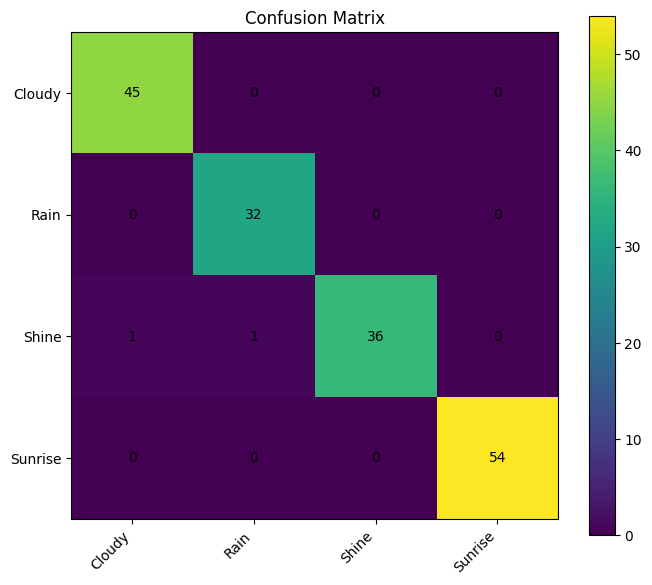

In [56]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(NUM_CLASSES), class_names, rotation=45, ha="right")
plt.yticks(range(NUM_CLASSES), class_names)

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


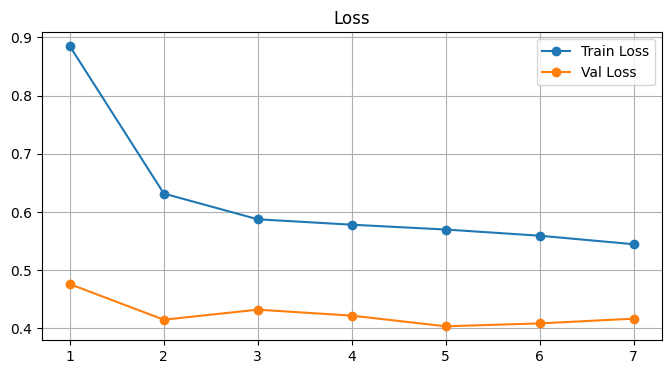

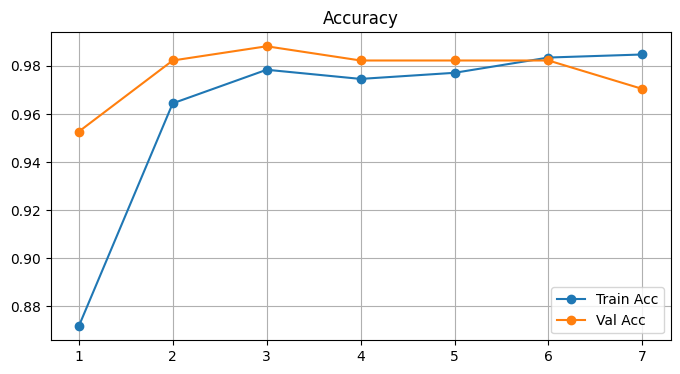

In [58]:
epochs_ran = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs_ran, history["train_loss"], marker="o", label="Train Loss")
plt.plot(epochs_ran, history["val_loss"], marker="o", label="Val Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs_ran, history["train_acc"], marker="o", label="Train Acc")
plt.plot(epochs_ran, history["val_acc"], marker="o", label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [60]:
import numpy as np
import torch

@torch.no_grad()
def collect_probs(model, loader, num_classes):
    model.eval()
    all_probs = []
    all_true = []

    for x, y in loader:
        x = x.to(DEVICE)

        out = model(x)
        if isinstance(out, tuple):
            out = out[0]  # Inception eval'de tuple dönebilir

        probs = torch.softmax(out, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_true.append(y.numpy())

    all_probs = np.vstack(all_probs)
    all_true = np.concatenate(all_true)
    return all_true, all_probs

y_true, y_prob = collect_probs(model, test_loader, NUM_CLASSES)
print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)


y_true shape: (169,)
y_prob shape: (169, 4)


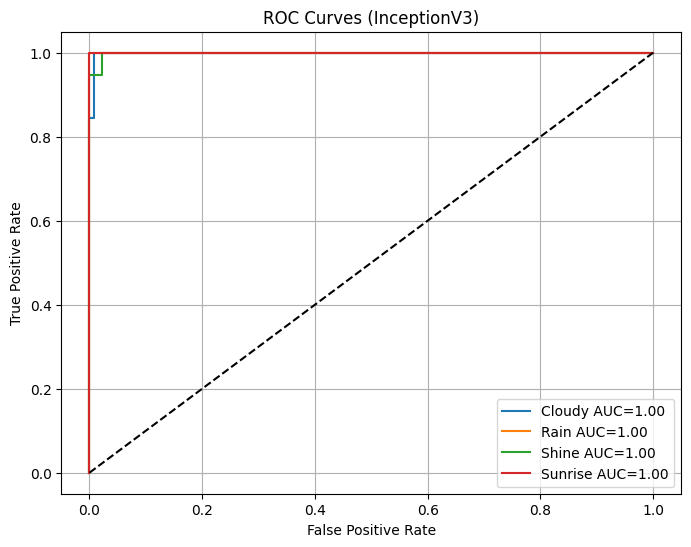

In [62]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))

plt.figure(figsize=(8,6))

for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} AUC={roc_auc:.2f}")

plt.plot([0, 1], [0, 1], "k--")  # random baseline
plt.title("ROC Curves (InceptionV3)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


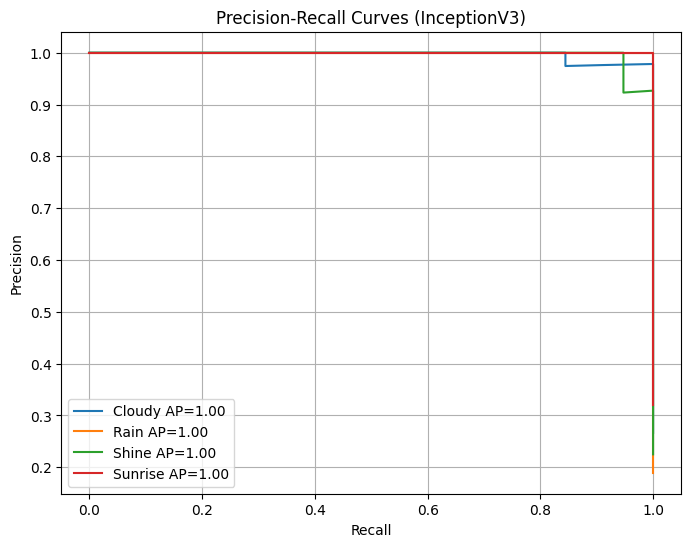

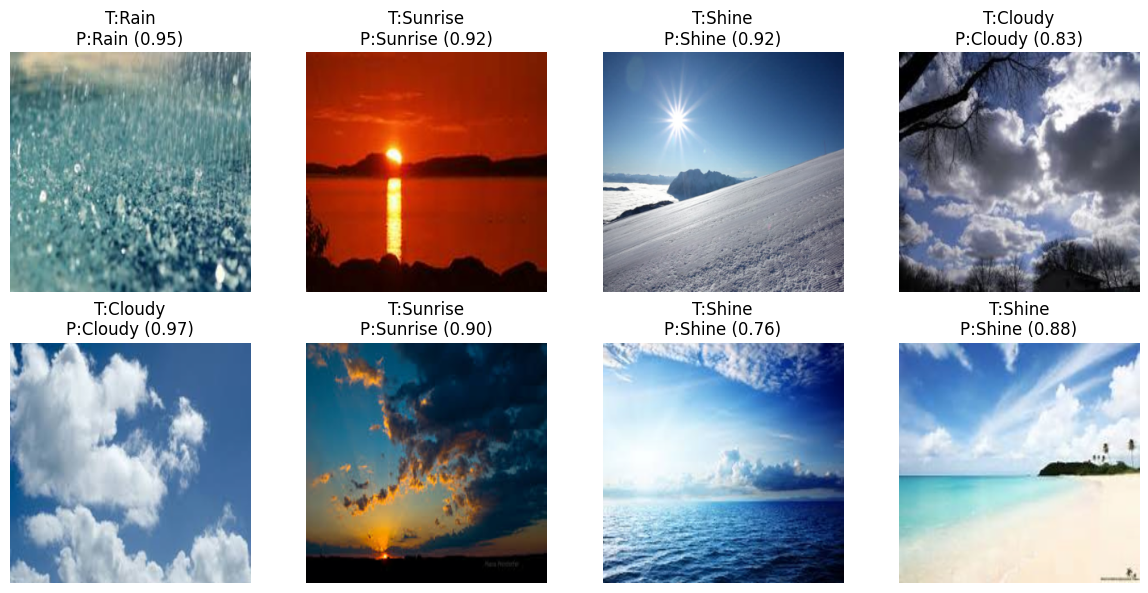

In [66]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import torch
import matplotlib.pyplot as plt

# -----------------------------
# Precision–Recall Curves
# -----------------------------
plt.figure(figsize=(8,6))
for i, cls in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"{cls} AP={ap:.2f}")

plt.title("Precision-Recall Curves (InceptionV3)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


# -----------------------------
# Sample Predictions
# -----------------------------
# test dataset'i burada tanımlıyoruz (NameError çözümü)
test_ds = WeatherDataset(test_p, test_y, eval_tf)

@torch.no_grad()
def show_samples(model, dataset, n=8):
    model.eval()
    idxs = np.random.choice(len(dataset), n, replace=False)

    plt.figure(figsize=(12,6))
    for i, idx in enumerate(idxs):
        x, y = dataset[idx]
        x_in = x.unsqueeze(0).to(DEVICE)

        out = model(x_in)
        if isinstance(out, tuple):
            out = out[0]

        prob = torch.softmax(out, dim=1)[0]
        pred = prob.argmax().item()

        # denormalize (clipping uyarısını kaldırır)
        img = x.permute(1,2,0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)

        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.title(f"T:{class_names[y]}\nP:{class_names[pred]} ({prob[pred]:.2f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# çağır
show_samples(model, test_ds, n=8)
